# A Julia birthday

Execute this notebook by repeatedly pressing shift + enter.

First, load some packages (this might take a while if this is your first Julia notebook on Juliabox). 

In [1]:
using PyPlot
using Interact

Next, read in the mesh.

In [2]:
p = readdlm("mesh.node");
t = readdlm("mesh.elem",Int64);
b = readdlm("boundary.elem",Int64); b = unique(b);

Function to compute element stiffness matrices.

In [3]:
function stiffness_matrix(vertices::Matrix{T}) where {T} 
    d = size(vertices,2)
    M = vcat(ones(T,1,d+1),vertices')
    G = M \ vcat(zeros(T,1,d),eye(T,d))

    return det(M) * Symmetric(G*G') / prod(1:d)
end

stiffness_matrix (generic function with 1 method)

Function to compose the finite element matrix and right hand side. 

In [4]:
function compose_fem_matrix(nodes::Matrix{T}, elements::Matrix{N}, f::Function, boundary::Vector{N}) where {T<:AbstractFloat,N<:Integer}
    
    nnodes,d = size(nodes)
    b = zeros(nnodes)
    I = Vector{Float64}()
    J = Vector{Float64}()
    V = Vector{Float64}()
    
    # loop over elements and compute element stiffness matrices
    for e in 1:size(elements,1)
        element = elements[e,:]
        coords = nodes[element,:]
        S = stiffness_matrix(coords)
        for i in 1:d+1
            for j in 1:d+1
                push!(I,element[i])
                push!(J,element[j])
                push!(V,S[i,j])
            end
        end
        M = vcat(ones(T,1,d+1),coords')
        b[element] += det(M)*f(sum(coords,2)/4)/24
    end
    
    # compose fem matrix
    A = sparse(I,J,V)
    
    # apply Dirichlet condition 
    free_nodes = setdiff(1:nnodes,boundary)
    A2 = speye(A)
    A2[free_nodes,free_nodes] = A[free_nodes,free_nodes]
    
    return A2, b
end

compose_fem_matrix (generic function with 1 method)

Compose the FEM matrix...

In [5]:
A, v = compose_fem_matrix(p, t, x -> ones(size(x,1)), b)

(
  [1   ,    1]  =  1.0
  [2   ,    2]  =  1.0
  [3   ,    3]  =  1.0
  [4   ,    4]  =  1.0
  [5   ,    5]  =  1.0
  [6   ,    6]  =  1.0
  [7   ,    7]  =  1.0
  [8   ,    8]  =  1.0
  [9   ,    9]  =  1.0
  [10  ,   10]  =  1.0
  ⋮
  [2552, 2552]  =  1.0
  [2553, 2553]  =  1.0
  [2554, 2554]  =  1.0
  [2555, 2555]  =  1.0
  [2556, 2556]  =  1.0
  [2557, 2557]  =  1.0
  [2558, 2558]  =  1.0
  [2559, 2559]  =  1.0
  [2560, 2560]  =  1.0
  [2561, 2561]  =  1.0
  [2562, 2562]  =  1.0, [0.00244078, 0.00544298, 0.0105905, 0.00440664, 0.010415, 0.00442371, 0.0104282, 0.00441964, 0.0104629, 0.0044065  …  0.0107671, 0.0107934, 0.0108265, 0.0108675, 0.0109176, 0.0109784, 0.0110532, 0.0111464, 0.0112958, 0.00529527])

... and find a solution.

In [6]:
f = A\v
f[b] = 0. # force boundary conditions towards 0

0.0

Finally, use the `Interact` package to make an interactive plot of the solution.

Use the sliders for the azimuth $\theta$ and elevation $\phi$ to change the view. It might take a while to update the plot...

Interact.Slider{Int64}(1: "input" = 260 Int64 , "θ", 260, 0:20:360, "horizontal", true, "d", true)

Interact.Slider{Int64}(3: "input-2" = 50 Int64 , "ϕ", 50, 0:10:90, "horizontal", true, "d", true)

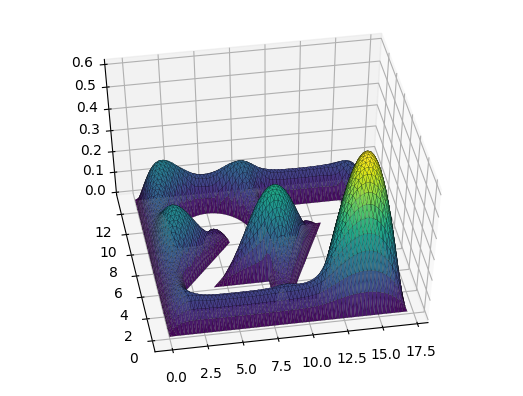

In [7]:
fig = figure()
@manipulate for θ = slider(0:20:360,value=260,label="θ"), ϕ = slider(0:10:90,value=50,label="ϕ")
    withfig(fig) do
        ax = subplot(111, projection="3d")
        ax[:azim] = θ; ax[:elev] = ϕ
        plot_trisurf(p[:,1],p[:,2],f,triangles=t-1,cmap=get_cmap("viridis"),edgecolors="k",linewidth=0.1)
    end
end